In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive

In [2]:
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/Colab Notebooks/AAI521-Hand-Gestures/kinect_leap_dataset/acquisitions/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# Function to parse Leap Motion CSV file
def parse_leap_motion_file(file_path):
    features = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) > 1:
                key = parts[0]
                values = [float(x) for x in parts[1:]]
                features[key] = values
    return features

# Function to load dataset
def load_dataset(base_path, sequence_length=100):
    rgb_data, depth_data, raw_depth_data, leap_data, labels = [], [], [], [], []
    leap_feature_keys = None

    for person in os.listdir(base_path):
        person_path = os.path.join(base_path, person)
        for gesture in os.listdir(person_path):
            gesture_path = os.path.join(person_path, gesture)
            for repetition in range(1, 11):  # Up to 10 repetitions
                label = f"{person}_{gesture}"

                # File paths
                rgb_file = os.path.join(gesture_path, f"{repetition}_rgb.png")
                depth_file = os.path.join(gesture_path, f"{repetition}_depth.png")
                raw_depth_file = os.path.join(gesture_path, f"{repetition}_depth.bin")
                leap_file = os.path.join(gesture_path, f"{repetition}_leap_motion.csv")

                if all(map(os.path.exists, [rgb_file, depth_file, raw_depth_file, leap_file])):
                    # Load RGB Image
                    rgb_img = cv2.imread(rgb_file)
                    rgb_resized = cv2.resize(rgb_img, (128, 128))
                    rgb_data.append(rgb_resized)

                    # Load Depth Map
                    depth_img = cv2.imread(depth_file, cv2.IMREAD_GRAYSCALE)
                    depth_resized = cv2.resize(depth_img, (128, 128))
                    depth_data.append(depth_resized)

                    # Load Raw Depth Data
                    raw_data = np.fromfile(raw_depth_file, dtype=np.uint16).reshape((480, 640))
                    raw_depth_resized = cv2.resize(raw_data, (128, 128))
                    raw_depth_data.append(raw_depth_resized)

                    # Load Leap Motion Data
                    leap_params = parse_leap_motion_file(leap_file)
                    if leap_feature_keys is None:
                        leap_feature_keys = list(leap_params.keys())
                    leap_values = [leap_params.get(key, [0.0]) for key in leap_feature_keys]
                    flattened_leap_values = [val for sublist in leap_values for val in sublist]
                    leap_data.append(flattened_leap_values)

                    # Append label
                    labels.append(label)

    # Normalize and pad data
    rgb_data = np.array(rgb_data) / 255.0
    depth_data = np.array(depth_data) / 255.0
    raw_depth_data = np.array(raw_depth_data)
    if np.max(raw_depth_data) > 0:
        raw_depth_data = raw_depth_data / np.max(raw_depth_data)
    leap_data = pad_sequences(leap_data, maxlen=sequence_length, padding='post', dtype='float32')
    leap_data = np.expand_dims(leap_data, axis=-1)  # Add feature dimension
    labels = np.array(labels)

    return rgb_data, depth_data, raw_depth_data, leap_data, labels

# Load Dataset
base_path = '/content/drive/My Drive/Colab Notebooks/AAI521-Hand-Gestures/kinect_leap_dataset/acquisitions/'
rgb_data, depth_data, raw_depth_data, leap_data, labels = load_dataset(base_path)


In [5]:
# Normalize Leap Motion data to [-1, 1]
leap_data = (leap_data - np.min(leap_data)) / (np.max(leap_data) - np.min(leap_data))
leap_data = leap_data * 2 - 1

# Filter Low-Variance Features
leap_variance = np.var(leap_data, axis=0)
low_variance_threshold = 1e-5
high_variance_indices = np.where(leap_variance > low_variance_threshold)[0]
filtered_leap_data = leap_data[:, high_variance_indices, :]

# Encode Labels
label_encoder = LabelEncoder()
gestures = [label.split('_')[1] for label in labels]  # Extract gesture (e.g., G1, G2)
labels_encoded = label_encoder.fit_transform(gestures)
labels_categorical = to_categorical(labels_encoded)

# Combine Image Data (RGB + Depth + Raw Depth)
combined_image_data = np.concatenate([rgb_data, depth_data[..., np.newaxis], raw_depth_data[..., np.newaxis]], axis=-1)

# Split Dataset
X_img_train, X_img_val, X_leap_train, X_leap_val, y_train, y_val = train_test_split(
    combined_image_data, filtered_leap_data, labels_categorical, test_size=0.2, stratify=labels_encoded, random_state=42
)

# Compute Class Weights
y_train_classes = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weights_dict = dict(enumerate(class_weights))

# Define Model Architecture
image_input = Input(shape=(128, 128, 5), name="image_input")  # 3 RGB + 1 Depth + 1 Raw Depth
x = Conv2D(64, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Leap Motion Branch
leap_input = Input(shape=(filtered_leap_data.shape[1], 1), name="leap_input")
y = LSTM(128, activation='relu', return_sequences=True)(leap_input)
y = LSTM(64, activation='relu')(y)
y = Dense(128, activation='relu')(y)
y = Dropout(0.5)(y)

# Fusion
combined = concatenate([x, y])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(len(label_encoder.classes_), activation='softmax')(z)

# Compile Model
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model = Model(inputs=[image_input, leap_input], outputs=output)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    [X_img_train, X_leap_train], y_train,
    validation_data=([X_img_val, X_leap_val], y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler, early_stopping]
)

# Save the Model
model.save('/content/drive/MyDrive/Colab Notebooks/AAI521-Hand-Gestures/hand_gesture_model.h5')

print("Model saved successfully!")


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.0927 - loss: 2.3866 - val_accuracy: 0.1036 - val_loss: 2.3027 - learning_rate: 1.0000e-04
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.0864 - loss: 2.3055 - val_accuracy: 0.1071 - val_loss: 2.3021 - learning_rate: 1.0000e-04
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.0927 - loss: 2.3005 - val_accuracy: 0.0964 - val_loss: 2.2999 - learning_rate: 1.0000e-04
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.1107 - loss: 2.2972 - val_accuracy: 0.1071 - val_loss: 2.2938 - learning_rate: 1.0000e-04
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.1274 - loss: 2.2908 - val_accuracy: 0.0964 - val_loss: 2.2867 - learning_rate: 1.0000e-04
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.1396 - loss: 2.2731 - val_accuracy: 0.1357 - val_loss: 2.2861 - learning_rate: 1.0000e-04
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 

Model saved successfully!


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 575ms/step - accuracy: 0.9356 - loss: 0.2629
Validation Accuracy: 0.93
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 825ms/step
              precision    recall  f1-score   support

          G1       0.93      1.00      0.97        28
         G10       0.81      0.93      0.87        28
          G2       1.00      0.93      0.96        28
          G3       0.93      0.93      0.93        28
          G4       0.93      0.89      0.91        28
          G5       0.90      0.96      0.93        28
          G6       0.96      0.82      0.88        28
          G7       1.00      0.93      0.96        28
          G8       0.87      0.93      0.90        28
          G9       0.96      0.93      0.95        28

    accuracy                           0.93       280
   macro avg       0.93      0.93      0.93       280
weighted avg       0.93      0.93      0.93       280



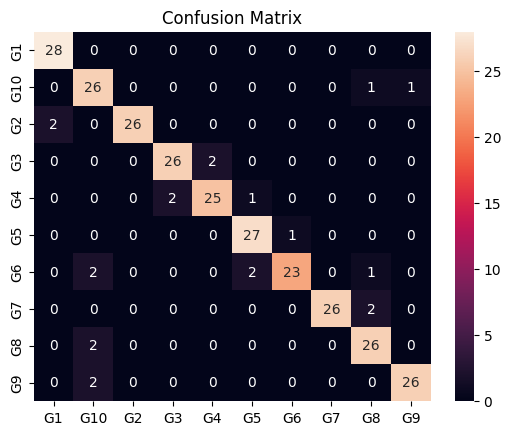

In [6]:
# Evaluate the Model
val_loss, val_accuracy = model.evaluate([X_img_val, X_leap_val], y_val)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
y_pred = model.predict([X_img_val, X_leap_val])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.show()

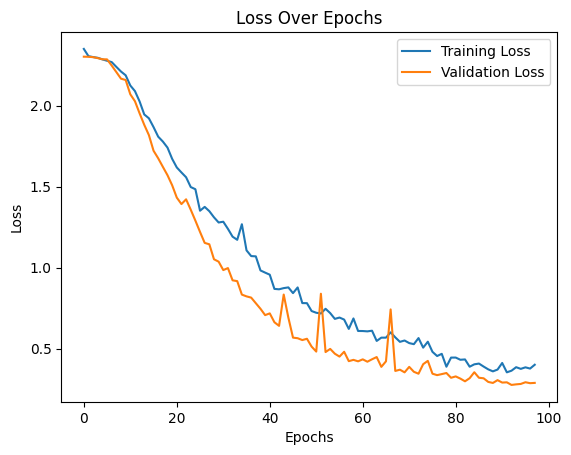

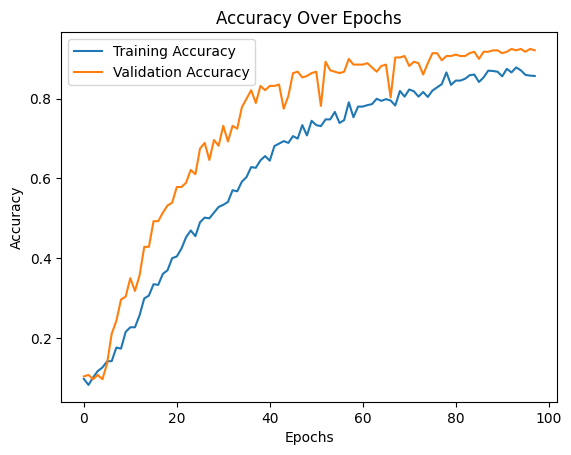

In [8]:
import matplotlib.pyplot as plt

# Loss Curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy Curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


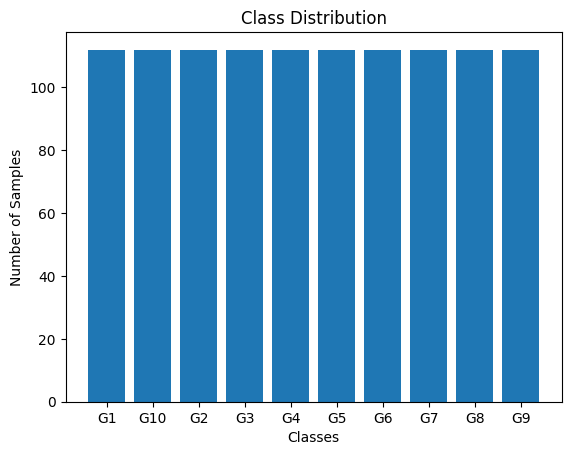

In [10]:
from collections import Counter
import numpy as np

class_counts = Counter(np.argmax(y_train, axis=1))
plt.bar(label_encoder.classes_, [class_counts[i] for i in range(len(label_encoder.classes_))])
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.show()
